# Conditional features in Bayesian optimization

When optimizing chemical processes, we often have some inputs that are dependent on others.
For example, the value of a `catalyst_concentration` input feature is only relevant depending
on another feature `use_catalyst==True`. Whilst it may seem that `use_catalyst==False` is
equivalent to just setting `catalyst_concentration==0`, there may be some limitations to 
this approach:
- If a catalyst is used, there may be some minimum amount required. It is difficult to model
 the disjoint bounds of a continuous feature.
- It may be the case that some tiny presence of catalyst enables a side reaction that completely
changes the reaction. We therefore have a step change at 0, with smoother behaviour everywhere
else in the domain, which Gaussian process surrogates cannot model well.

For a some examples of literature on these problems, see [Swersky2014Arc] and [Horn2019Wedge].

[Swersky2014Arc] Swersky et al. 2014, "Raiders of the Lost Architecture: Kernels for Bayesian Optimization in Conditional Parameter Spaces" arXiv    
[Horn2019Wedge] Horn et al. "Surrogates for hierarchical search spaces: the wedge-kernel and an automated analysis", GECCO

We consider a test problem as described above, where we wish to optimize the yield of
a reaction by controlling the temperature and catalyst concentration.

In [ ]:
from bofire.data_models.constraints.api import NonZeroCondition
from bofire.data_models.domain.api import Domain
from bofire.data_models.features.api import ContinuousInput, ContinuousOutput


domain = Domain.from_lists(
    inputs=[
        ContinuousInput(key="temperature", unit="°C", bounds=(50, 100)),
        ContinuousInput(
            key="catalyst_concentration",
            unit="mol/L",
            bounds=(0.5, 1.0),
            allow_zero=True,
        ),
    ],
    outputs=[ContinuousOutput(key="yield")],
)

After defining the domain, we can then build the wedge kernel for our GP surrogate. We
also briefly check that it behaves as intended in the cells below:

In [ ]:
from bofire.data_models.kernels.api import RBFKernel, WedgeKernel


# here, we manually build the list of conditions
# in future we will automatically build them from any inputs with allow_inactive==True
conditions = [
    (
        "catalyst_concentration",
        "catalyst_concentration",
        NonZeroCondition(),
    )
]

wedge_kernel_data_model = WedgeKernel(
    base_kernel=RBFKernel(),
    conditions=conditions,
    # since the indicator feature is also used in the surrogate, don't drop it
    drop_indicator_features_in_base_kernel=False,
)

In [ ]:
import torch

import bofire.kernels.api as kernels


def features_to_idx_mapper(feats: list[str]) -> list[int]:
    return domain.inputs.get_feature_indices({}, feats)


wedge_kernel = kernels.map(
    wedge_kernel_data_model,
    batch_shape=torch.Size([]),
    active_dims=list(range(2)),
    features_to_idx_mapper=features_to_idx_mapper,
)

In [ ]:
# cast the return type from `kernels.map` to the wedge kernel
# this fixes syntax highlighting in this notebook
from typing import cast

from bofire.kernels.conditional import WedgeKernel as WedgeKernelFunctional


wedge_kernel = cast(WedgeKernelFunctional, wedge_kernel)
wedge_kernel

WedgeKernel(
  (raw_lengthscale_constraint): Positive()
  (raw_angle_constraint): Interval(1.000E-04, 9.999E-01)
  (raw_radius_constraint): Positive()
  (base_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
)

In [ ]:
# check the order of dimensions in X
assert features_to_idx_mapper(["catalyst_concentration", "temperature"]) == [0, 1]

X = torch.tensor(
    [
        [
            0.0,
            0.0,
        ],
        [
            0.05,
            0.0,
        ],
        [
            0.50,
            0.6,
        ],
    ]
)

# the indicator function shows which dimensions are active
# X[:, 1] should always be active
# X[:, 0] should only be active if X[:, 0] != 0
wedge_kernel.indicator_func(X)

tensor([[False,  True],
        [ True,  True],
        [ True,  True]])

## Using the wedge kernel for Bayesian optimizaiton

Using the domain defined at the start of the notebook, we now create a benchmark that
we can use to evaluate how well this kernel works for Bayesian optimization.

We set up our objective function such that adding a catalyst enables a side reaction,
and so any small prescence of the catalyst hurts yield. However, at higher concentration
of catalyst, we see improved performance.

Increasing temperature increases the yield, however it also causes decomposition of the
catalyst at high temperatures.

In [ ]:
import numpy as np
import pandas as pd

from bofire.benchmarks.api import Benchmark


class ReactionOptimizationBenchmark(Benchmark):
    _domain = domain

    def _f(self, X: pd.DataFrame, **kwargs) -> pd.DataFrame:  # type: ignore
        cat_conc = X["catalyst_concentration"]
        temp = X["temperature"]
        norm_temp = (temp - 50) / 50

        side_product = np.where(cat_conc > 0.0, 10.0, 0.0)
        effective_catalyst = np.clip(cat_conc - 1.5 * (norm_temp - 0.5), 0.0, cat_conc)

        catalyst_effect = 10 * np.exp(effective_catalyst)
        temperature_effect = 10 * np.exp(norm_temp)
        y = temperature_effect + catalyst_effect - side_product

        Y = pd.DataFrame({"yield": y, "valid_yield": 1})
        return Y


benchmark = ReactionOptimizationBenchmark()

Text(0, 0.5, 'temperature')

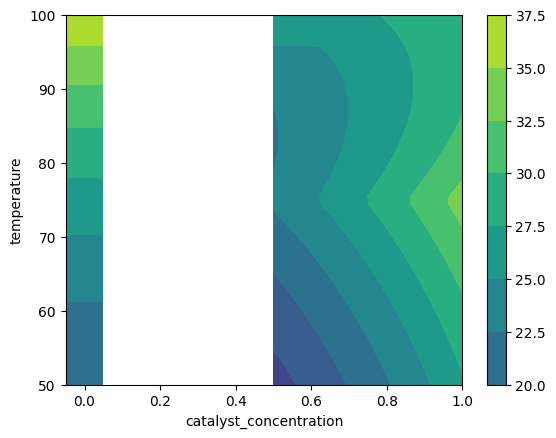

In [ ]:
import matplotlib.pyplot as plt


N_grid_pts = 50
# plot active points
X_c, X_t = np.meshgrid(
    np.linspace(0.5, 1.0, num=N_grid_pts), np.linspace(50, 100, num=N_grid_pts)
)
grid_X = np.stack((X_c.flatten(), X_t.flatten()), axis=-1)
grid_Y = benchmark.f(
    pd.DataFrame(data=grid_X, columns=["catalyst_concentration", "temperature"])
)["yield"].to_numpy()
plt.contourf(X_c, X_t, grid_Y.reshape(N_grid_pts, N_grid_pts), vmin=10, vmax=40)

# plot inactive points
X_c, X_t = np.meshgrid(
    np.linspace(-0.05, 0.05, num=2), np.linspace(50, 100, num=N_grid_pts)
)
grid_X = np.stack((0.0 * X_c.flatten(), X_t.flatten()), axis=-1)
grid_Y = benchmark.f(
    pd.DataFrame(data=grid_X, columns=["catalyst_concentration", "temperature"])
)["yield"].to_numpy()
plt.contourf(X_c, X_t, grid_Y.reshape(N_grid_pts, 2), vmin=10, vmax=40)

plt.colorbar()
plt.xlabel("catalyst_concentration")
plt.ylabel("temperature")

In [ ]:
import bofire.strategies.api as strategies
from bofire.data_models.strategies.api import RandomStrategy, SoboStrategy


samples = strategies.map(RandomStrategy(domain=domain, seed=1)).ask(10)
experiments = benchmark.f(samples, return_complete=True)
experiments.head(4)

,catalyst_concentration,temperature,yield,valid_yield
0,0.845433,95.363403,27.418609,1
1,0.518452,76.386904,23.060772,1
2,0.717979,57.188481,22.049029,1
3,0.525205,72.975285,22.740970,1


In [ ]:
from bofire.data_models.surrogates.api import BotorchSurrogates, SingleTaskGPSurrogate


sobo_strategy_data_model = SoboStrategy(
    domain=domain,
    seed=1,
    surrogate_specs=BotorchSurrogates(
        surrogates=[
            SingleTaskGPSurrogate(
                inputs=domain.inputs,
                outputs=domain.outputs,
                kernel=wedge_kernel_data_model,
            )
        ]
    ),
)
strategy = strategies.map(sobo_strategy_data_model)

In [ ]:
strategy.tell(experiments, replace=True)

In [ ]:
strategy.ask(5)

,catalyst_concentration,temperature,yield_pred,yield_sd,yield_des
0,1.0,100.000000,29.661563,0.552186,29.661563
1,0.0,100.000000,26.413223,2.514311,26.413223
2,1.0,85.801242,29.430370,0.752132,29.430370
3,0.0,50.000000,25.947872,2.505550,25.947872
4,0.0,76.170535,26.090478,2.456480,26.090478
